In [1]:
import os
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from typing import List, Tuple, Union
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [2]:
os.environ["DATASET"] = "UPB2012"
os.environ["DISSEMINATION"]= "true"
os.environ["MODEL"] = "decision"

In [3]:

dataset_filename = f"dataset/{os.environ.get('DATASET')}/useful_messages"

if os.environ.get('DISSEMINATION') == 'true':
    dataset_filename += "_dissemination"

dataset_filename += '.csv'

os.chdir("c:\\Users\\sebastian.pitur\\Documents\\facultate\\mobemu")


df = pd.read_csv(dataset_filename)

In [4]:
df = df.rename(columns={'oldFriendWithDestination': 'oldCommonTopicWithMessage'})
df = df.rename(columns={'newFriendWithDestination': 'newCommonTopicWithMessage'})

positive_df = df.loc[df["usefulTransfer"] == 1]
negative_df = df.loc[df["usefulTransfer"] == 0]

lesser_len = positive_df.shape[0] if positive_df.shape[0] < negative_df.shape[0] else negative_df.shape[0]

positive_df = positive_df.sample(lesser_len)
negative_df = negative_df.sample(lesser_len)

balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
preprocessed_df = balanced_df.drop(columns="usefulTransfer").copy()


In [5]:

from sklearn.tree import DecisionTreeClassifier


minmax_columns = ["messageHopCount"]

# categorial_columns = [
#     "oldFriendWithDestination",
#     "oldCommonCommunity",
#     "newFriendWithDestination",
#     "newCommonCommunity",
# ]

categorial_columns = [
    "oldCommonTopicWithMessage",
    "oldCommonCommunity",
    "newCommonTopicWithMessage",
    "newCommonCommunity",
]

standard_columns = [
    col
    for col in preprocessed_df.select_dtypes(include=["float64", "int64"]).columns
    if col not in minmax_columns and col not in categorial_columns
]

TransformerType = Union[MinMaxScaler, StandardScaler, OneHotEncoder]

transformers: List[Tuple[str, TransformerType, List[str]]] = []

if os.environ.get("DISSEMINATION") != "true":
    transformers = [
        ("minmax", MinMaxScaler((0, 1)), minmax_columns),
    ]

transformers.extend([
        ("standard", StandardScaler(), standard_columns),
        ("onehotencoder", OneHotEncoder(), categorial_columns)
    ])

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="passthrough",
)

preprocessed_df = preprocessor.fit_transform(preprocessed_df)
X = balanced_df.copy().drop(columns=["usefulTransfer"])
result_df = pd.DataFrame(balanced_df["usefulTransfer"].copy().squeeze())
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(result_df)


c:\Users\sebastian.pitur\Documents\facultate\mobemu\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision tree model chosen


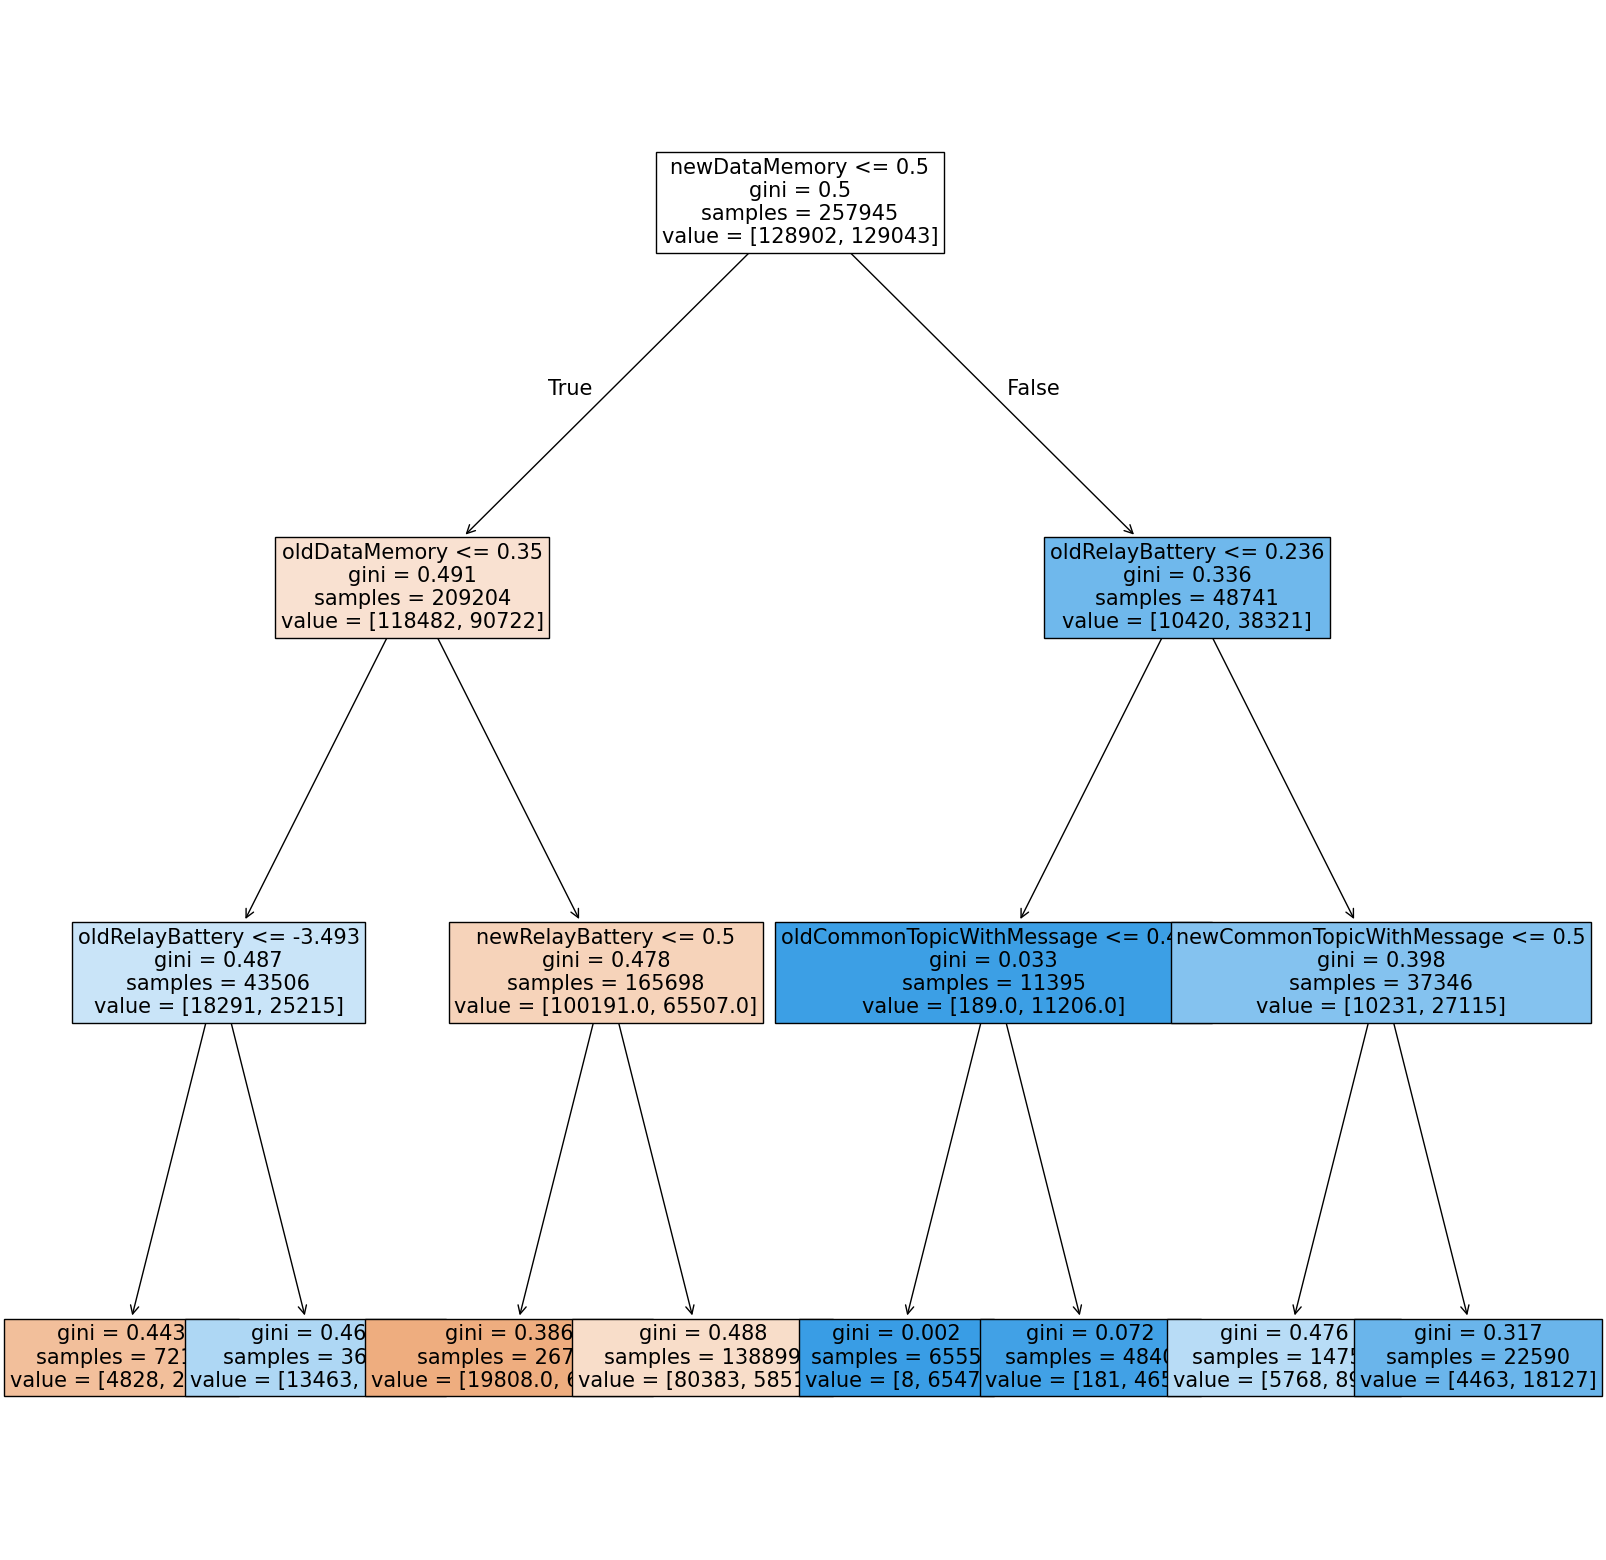

c:\Users\sebastian.pitur\Documents\facultate\mobemu\.venv\lib\site-packages\sklearn2pmml\pipeline\__init__.py:72: UserWarning: y is missing target field name(s)
  warnings.warn("y is missing target field name(s)")


Saving model at c:\Users\sebastian.pitur\Documents\facultate\mobemu\src\main\resources with the name model-decision-UPB2012_dissemination.pmml


In [7]:

def display_metrics(y_test, y_pred, save=False):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    display_func = print

    if save:
        filename = f"metrics-{os.environ['MODEL']}"

        if "DISSEMINATION" in os.environ and os.environ["DISSEMINATION"] == 'true':
            filename += "-dissemination"

        filename += ".txt"
        f = open(f"metrics-{os.environ['MODEL']}.txt", "w")
        display_func = f.write
    display_func("Number of entries trained on: " + str(5 * len(y_test)) + "\n")
    display_func(f"Accuracy: {accuracy:.2f}\n")
    display_func("Classification Report:\n")
    display_func(str(classification_report(y_test, y_pred)) + "\n")
    display_func("Confusion Matrix:\n")
    display_func(str(confusion_matrix(y_test, y_pred)) + "\n")

    if save:
        f.close()


def train_neural(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = MLPClassifier(
        solver="lbfgs",
        activation="relu",
        alpha=1e-5,
        hidden_layer_sizes=(64, 32),
        random_state=42,
        max_iter=5000,
    )

    # Build the pipeline
    neural_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])

    neural_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = neural_pipeline.predict(X_test)

    # Create a PMML pipeline
    pmml_pipeline = PMMLPipeline([("preprocessor", preprocessor), ("classifier", clf)])

    base_working_dir = os.getcwd()

    # Export the model to PMML
    os.chdir(f"{base_working_dir}/src/main/resources")
    model_name = f"model-neural-{os.environ.get('DATASET')}"

    if os.environ.get('DISSEMINATION') == 'true':
        model_name += "_dissemination"

    model_name += ".pmml"

    print(f"Saving model at {os.getcwd()} with name {model_name}")

    sklearn2pmml(pmml_pipeline, model_name)

    os.chdir(f"{base_working_dir}/dataset/{os.environ.get('DATASET')}")
    display_metrics(y_test, y_pred, save=True)


def train_svm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    base = svm.SVC(kernel="rbf")

    # Hyperparameter tuning using Grid Search
    param_grid = {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],  # Kernel coefficient
    }

    grid_poly = GridSearchCV(base, param_grid, refit=True, cv=5)
    grid_poly.fit(X_train, y_train)

    best_svm = grid_poly.best_estimator_

    # Build the pipeline
    svm_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", best_svm)])

    svm_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_pipeline.predict(X_test)

    # Create a PMML pipeline
    pmml_pipeline = PMMLPipeline(
        [("preprocessor", preprocessor), ("classifier", best_svm)]
    )

    base_working_dir = os.getcwd()
    pmml_pipeline.fit(X_train, y_train)

    # Export the model to PMML
    os.chdir(f"{base_working_dir}/src/main/resources")
    model_name = f"model-svm-{os.environ.get('DATASET')}"

    if os.environ.get('DISSEMINATION') == 'true':
        model_name += "_dissemination"

    model_name += ".pmml"

    print(f"Saving model at {os.getcwd()} with the name {model_name}")
    sklearn2pmml(pmml_pipeline, model_name)

    os.chdir(f"{base_working_dir}/dataset/{os.environ.get('DATASET')}")
    display_metrics(y_test, y_pred, save=True)


def train_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Build the pipeline
    rf_pipeline = Pipeline(
        [("preprocessor", preprocessor), ("classifier", rf_classifier)]
    )

    rf_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_pipeline.predict(X_test)

    # Create a PMML pipeline
    pmml_pipeline = PMMLPipeline(
        [("preprocessor", preprocessor), ("classifier", rf_classifier)]
    )

    base_working_dir = os.getcwd()
    pmml_pipeline.fit(X_train, y_train)

    # Export the model to PMML
    os.chdir(f"{base_working_dir}/src/main/resources")
    model_name = f"model-rf-{os.environ.get('DATASET')}"

    if os.environ.get('DISSEMINATION') == 'true':
        model_name += "_dissemination"

    model_name += ".pmml"

    print(f"Saving model at {os.getcwd()} with the name {model_name}")

    sklearn2pmml(pmml_pipeline, model_name)

    os.chdir(f"{base_working_dir}/dataset/{os.environ.get('DATASET')}")
    display_metrics(y_test, y_pred, save=True)

def train_decision_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    decission_tree_classifier = DecisionTreeClassifier(max_depth=3)

    # Build the pipeline
    decision_pipeline = Pipeline(
        [("preprocessor", preprocessor), ("classifier", decission_tree_classifier)]
    )

    decision_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = decision_pipeline.predict(X_test)


    plt.figure(figsize=(20,20))
    plot_tree(decision_pipeline.named_steps["classifier"], feature_names=X.columns, filled=True, fontsize=15)
    plt.show()

    # Create a PMML pipeline
    pmml_pipeline = PMMLPipeline(
        [("preprocessor", preprocessor), ("classifier", decission_tree_classifier)]
    )

    base_working_dir = os.getcwd()
    pmml_pipeline.fit(X_train, y_train)

    # Export the model to PMML
    os.chdir(f"{base_working_dir}/src/main/resources")
    model_name = f"model-decision-{os.environ.get('DATASET')}"

    if os.environ.get('DISSEMINATION') == 'true':
        model_name += "_dissemination"

    model_name += ".pmml"

    print(f"Saving model at {os.getcwd()} with the name {model_name}")

    sklearn2pmml(pmml_pipeline, model_name)

    os.chdir(f"{base_working_dir}/dataset/{os.environ.get('DATASET')}")
    display_metrics(y_test, y_pred, save=True)

if os.environ.get("MODEL") == "rf":
    print("Random forest model chosen")
    train_random_forest(X, y)
elif os.environ.get("MODEL") == "neural":
    print("Neural network chosen")
    train_neural(X, y)
elif os.environ.get("MODEL") == "svm":
    print("SVM model chosen")
    train_svm(X, y)
elif os.environ.get("MODEL") == "decision":
    print("Decision tree model chosen")
    train_decision_tree(X, y)
